In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [202]:
class Task():
    def __init__(self, period, execution_time, deadline ):
        self.period = period
        self.execution_time = execution_time
        self.deadline = deadline
        self.priority = None

    def __repr__(self) -> str:
        return "Task: " +  str(self.period) +" " + str(self.execution_time) + " " + str(self.deadline) + " " + str(self.priority)

class TaskSet():

    def __init__(self, n, ut, min_period, max_period):
        self.n = n
        self.ut = ut
        self.min_period = min_period
        self.max_period = max_period
        self.tasks = None

    def generate(self):
        self.utilities = self.uunifastdiscard()
        if self.utilities is None:
            print("Failed to generate taskset with given parameters")
            return False

        self.periods = self.periods_generation()
        self.execution_time = self.execution_times()
        self.deadline = self.task_deadlines()

        self.tasks = []
        for i in range(self.n):
            self.tasks.append(Task(self.periods[i],self.execution_time[i],self.deadline[i]))
        return True
        

    def uunifastdiscard(self,discard_limit = 1000):
        sumu = self.ut
        for j in range(discard_limit):
            utilities = []
            for i in range(1,self.n):
                nextsumu = sumu*(np.random.random()**(1.0/(self.n-1)))
                utilities.append(sumu - nextsumu)
                sumu = nextsumu

            utilities.append(sumu)

            if all(ut <= 1 for ut in utilities):
                return np.array(utilities)
            else:
                sumu = self.ut

        return None
    
    def periods_generation(self):
        periods = np.ceil(np.exp(np.random.uniform(low=np.log(self.min_period), high=np.log(self.max_period),size=(self.n))))
        return periods
    
    def execution_times(self):
        return np.ceil(self.utilities * self.periods)
    
    def task_deadlines(self):
        deadline = []
        for i in range(len(self.execution_time)):
            deadline.append(np.random.uniform(low = self.execution_time[i] , high = self.periods[i]))

        return np.floor(np.array(deadline))

            


In [6]:
def DMPO(set):
    set.sort(key = lambda x:x.deadline)

In [7]:
def D_CMPO(taskset):
    taskset.sort(key = lambda x:x.deadline - x.execution_time)

In [8]:
def DkC(taskset,m):
    k = ((m - 1) + np.sqrt(5*m**2 - 6*m + 1))/(2*m)
    taskset.sort(key = lambda x:x.deadline - k*x.execution_time)    

In [10]:
cores = 4
taskset = TaskSet(cores*5,1,10,100)

taskset.generate()
print(taskset.tasks)

[Task: 20.0 1.0 5.0 None, Task: 90.0 7.0 69.0 None, Task: 45.0 2.0 4.0 None, Task: 17.0 1.0 14.0 None, Task: 66.0 2.0 4.0 None, Task: 48.0 1.0 2.0 None, Task: 37.0 6.0 36.0 None, Task: 23.0 2.0 8.0 None, Task: 62.0 1.0 59.0 None, Task: 66.0 7.0 37.0 None, Task: 19.0 1.0 2.0 None, Task: 47.0 2.0 43.0 None, Task: 32.0 1.0 18.0 None, Task: 24.0 3.0 14.0 None, Task: 56.0 1.0 27.0 None, Task: 11.0 1.0 9.0 None, Task: 74.0 4.0 63.0 None, Task: 65.0 3.0 41.0 None, Task: 58.0 3.0 54.0 None, Task: 76.0 10.0 68.0 None]


In [8]:
DMPO(taskset.tasks)
print(taskset.tasks)

[Task: 35.0 1.0 1.0 None, Task: 23.0 2.0 3.0 None, Task: 12.0 1.0 3.0 None, Task: 23.0 1.0 4.0 None, Task: 21.0 3.0 8.0 None, Task: 36.0 1.0 9.0 None, Task: 14.0 2.0 9.0 None, Task: 11.0 1.0 10.0 None, Task: 21.0 1.0 13.0 None, Task: 27.0 1.0 13.0 None, Task: 97.0 1.0 17.0 None, Task: 18.0 3.0 17.0 None, Task: 74.0 2.0 18.0 None, Task: 71.0 3.0 18.0 None, Task: 91.0 10.0 20.0 None, Task: 24.0 1.0 20.0 None, Task: 71.0 5.0 23.0 None, Task: 24.0 2.0 23.0 None, Task: 64.0 2.0 25.0 None, Task: 51.0 4.0 26.0 None]


In [9]:
D_CMPO(taskset.tasks)
print(taskset.tasks)

[Task: 35.0 1.0 1.0 None, Task: 23.0 2.0 3.0 None, Task: 12.0 1.0 3.0 None, Task: 23.0 1.0 4.0 None, Task: 21.0 3.0 8.0 None, Task: 14.0 2.0 9.0 None, Task: 36.0 1.0 9.0 None, Task: 11.0 1.0 10.0 None, Task: 91.0 10.0 20.0 None, Task: 21.0 1.0 13.0 None, Task: 27.0 1.0 13.0 None, Task: 18.0 3.0 17.0 None, Task: 71.0 3.0 18.0 None, Task: 97.0 1.0 17.0 None, Task: 74.0 2.0 18.0 None, Task: 71.0 5.0 23.0 None, Task: 24.0 1.0 20.0 None, Task: 24.0 2.0 23.0 None, Task: 51.0 4.0 26.0 None, Task: 64.0 2.0 25.0 None]


In [10]:
DkC(taskset.tasks,cores)
print(taskset.tasks)

[Task: 35.0 1.0 1.0 None, Task: 23.0 2.0 3.0 None, Task: 12.0 1.0 3.0 None, Task: 23.0 1.0 4.0 None, Task: 21.0 3.0 8.0 None, Task: 14.0 2.0 9.0 None, Task: 91.0 10.0 20.0 None, Task: 36.0 1.0 9.0 None, Task: 11.0 1.0 10.0 None, Task: 21.0 1.0 13.0 None, Task: 27.0 1.0 13.0 None, Task: 18.0 3.0 17.0 None, Task: 71.0 3.0 18.0 None, Task: 74.0 2.0 18.0 None, Task: 97.0 1.0 17.0 None, Task: 71.0 5.0 23.0 None, Task: 24.0 1.0 20.0 None, Task: 24.0 2.0 23.0 None, Task: 51.0 4.0 26.0 None, Task: 64.0 2.0 25.0 None]


In [193]:
def OPA(taskset, cores, S_test):
    N = len(taskset)

    assigned_tasks = []

    taskset_copy = taskset.copy()

    priority_assigned = [False] * N

    for i in range(N-1,-1,-1):

        for j,task in enumerate(taskset_copy):

            if not priority_assigned[j]:
                if(S_test([task] +assigned_tasks,cores)):
                    task.priority = i
                    priority_assigned[j] = True
                    assigned_tasks = [task] + assigned_tasks
                    break
        else:
            return False
            return taskset_copy,(i)/N*100
    return True
    return taskset_copy,100

In [194]:
def deadline_analysis_OPA(ptaskset,m):    #taskset = {period,execution time,deadline}
    Ck = ptaskset[0].execution_time
    Dk = ptaskset[0].deadline
    l = Dk
    total_workload = 0

    for task in ptaskset[1:]:
        Ti,Ci,Di = task.period,task.execution_time,task.deadline
        max_jobs = np.floor(( l + Di - Ci )/Ti)
        workload_task = max_jobs*Ci + min(Ci,l + Di - Ci - max_jobs*Ti)
        workload_task = min(workload_task,Dk - Ck + 1)
        total_workload += workload_task

    thresh = Ck + np.floor(total_workload/m)
    if Dk < thresh/m:
        return 0
    return 1

In [195]:
def deadline_analysis(ptaskset,m):    #taskset = {period,execution time,deadline}
    num_tasks = len(ptaskset)
    cleared = 0
    for k in range(num_tasks):
        
        total_workload = 0
        Ck,Dk = ptaskset[k].execution_time,ptaskset[k].deadline
        l = Dk
        for i in range(k):
            Ti,Ci,Di = ptaskset[i].period,ptaskset[i].execution_time,ptaskset[i].deadline
            max_jobs = np.floor(( l + Di - Ci )/Ti)
            workload_j = max_jobs*Ci + min(Ci,l + Di - Ci - max_jobs*Ti)
            workload_j = min(workload_j,Dk - Ck+1)
            total_workload += workload_j

        thresh = Ck + np.floor(total_workload/m)
        if Dk >= thresh:
            cleared += 1

    if cleared == num_tasks:
        return True
    else:
        return False
    return (cleared/num_tasks)*100

In [148]:
def responsetimeanalysis(ptaskset,m):
    num_tasks = len(ptaskset)
    cleared = 0
    for k in range(num_tasks):
        Ck,Dk = ptaskset[k].execution_time,ptaskset[k].deadline
        l = Dk
        res = Ck
        new_res = Ck
        if k == 0:
            if res <= Dk:
                cleared+=1
                continue

        while new_res <= Dk :
            res = new_res
            total_workload = 0
            for i in range(k):
                Ti,Ci = ptaskset[i].period,ptaskset[i].execution_time
                max_jobs = np.floor(( l + res - Ci )/Ti)
                workload_j = max_jobs*Ci + min(Ci,l + res - Ci - max_jobs*Ti)
                workload_j = min(workload_j,res - Ck + 1)
                total_workload += workload_j/m

            new_res = Ck + np.floor(total_workload)

            # print(new_res, res)
            if new_res - res < 0:
                if(res-new_res < 0.1):
                    break
            if new_res-res < 0.1 :
                break

        if new_res <= Dk :
            cleared += 1

    if cleared == num_tasks:
        return True
    else:
        return False

In [14]:
def generate_tasksets(n_tasksets, n_tasks, max_utility, min_period, max_period):
    set_tasksets = []
    for i in range(n_tasksets):
        set = TaskSet(n_tasks,max_utility,min_period,max_period)
        set.generate()
        set_tasksets.append(set)
    
    return set_tasksets

In [203]:
set_tasksets = []
n_tasksets = 1000

cores = 2
n_tasks = 5*cores
min_period = 100
max_period = 1000000
us = np.arange(0.1,cores,0.1)


percentage_schedulable_OPA = []
percentage_schedulable_DMPO = []
percentage_schedulable_D_CMPO = []
percentage_schedulable_DkC = []
for u in us:
    percentage_OPA = 0
    percentage_DCMPO = 0
    percentage_DMPO = 0
    percentage_DkC = 0
    set_tasksets = generate_tasksets(n_tasksets, n_tasks, u, min_period, max_period)
    for i in range(n_tasksets):
        set = set_tasksets[i]
        # ordered_tasks,percentage = OPA(set.tasks, cores, deadline_analysis_OPA)
        # percentage_OPA += percentage
        # D_CMPO(set.tasks)
        percentage_OPA += int(OPA(set.tasks, cores, deadline_analysis))
        

        set = set_tasksets[i]
        DMPO(set.tasks)
        # percentage_DMPO += deadline_analysis(set.tasks,cores)
        percentage_DMPO += int(deadline_analysis(set.tasks,cores))

        set = set_tasksets[i]
        D_CMPO(set.tasks)
        # percentage_DCMPO += deadline_analysis(set.tasks,cores)
        percentage_DCMPO += int(deadline_analysis(set.tasks,cores))

        set = set_tasksets[i]
        DkC(set.tasks,cores)
        # percentage_DkC += deadline_analysis(set.tasks,cores)
        percentage_DkC += int(deadline_analysis(set.tasks,cores))

    percentage_schedulable_OPA.append(percentage_OPA/n_tasksets)
    percentage_schedulable_DMPO.append(percentage_DMPO/n_tasksets)
    percentage_schedulable_D_CMPO.append(percentage_DCMPO/n_tasksets)
    percentage_schedulable_DkC.append(percentage_DkC/n_tasksets)
        


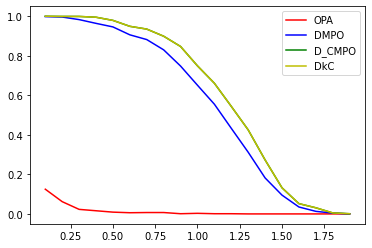

In [204]:
plt.figure()
plt.plot(us,percentage_schedulable_OPA,color='r',label='OPA')
plt.plot(us,percentage_schedulable_DMPO,color='b',label='DMPO')
plt.plot(us,percentage_schedulable_D_CMPO,color='g',label='D_CMPO')
plt.plot(us,percentage_schedulable_DkC,color='y',label='DkC',linestyle='-')
plt.legend()



In [121]:
set_tasksets = []
n_tasksets = 100

cores = 4
n_tasks = 5*cores
min_period = 100
max_period = 100000
us = np.arange(0.1,4,0.1)


percentage_schedulable_OPA = []
percentage_schedulable_DMPO = []
percentage_schedulable_D_CMPO = []
percentage_schedulable_DkC = []
for u in us:
    percentage_OPA = 0
    percentage_DCMPO = 0
    percentage_DMPO = 0
    percentage_DkC = 0
    set_tasksets = generate_tasksets(n_tasksets, n_tasks, u, min_period, max_period)
    for i in range(n_tasksets):
        

        set = set_tasksets[i]
        DMPO(set.tasks)
        percentage_DMPO += responsetimeanalysis(set.tasks,cores)

        set = set_tasksets[i]
        D_CMPO(set.tasks)
        percentage_DCMPO += responsetimeanalysis(set.tasks,cores)

        set = set_tasksets[i]
        DkC(set.tasks,cores)
        percentage_DkC += responsetimeanalysis(set.tasks,cores)

    # percentage_schedulable_OPA.append(percentage_OPA/n_tasksets)
    percentage_schedulable_DMPO.append(percentage_DMPO/n_tasksets)
    percentage_schedulable_D_CMPO.append(percentage_DCMPO/n_tasksets)
    percentage_schedulable_DkC.append(percentage_DkC/n_tasksets)
        


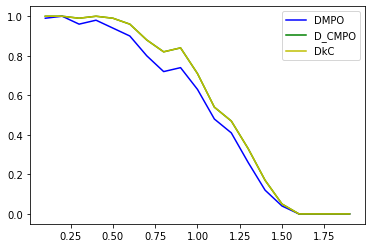

In [124]:
plt.figure()
# plt.plot(us,percentage_schedulable_OPA,color='r',label='OPA')
plt.plot(us,percentage_schedulable_DMPO,color='b',label='DMPO')
plt.plot(us,percentage_schedulable_D_CMPO,color='g',label='D_CMPO')
plt.plot(us,percentage_schedulable_DkC,color='y',label='DkC',linestyle='-')
plt.legend()



In [51]:
sett = TaskSet(10,0.2,10,100)
sett.generate()

DMPO(sett.tasks)
x = responsetimeanalysis(sett.tasks,2)
print(x)

100.0
